In [1]:
!kaggle datasets download vipoooool/new-plant-diseases-dataset

/bin/bash: line 1: kaggle: command not found


In [1]:
import os
import glob
import keras
import tensorflow as tf
import numpy as np
from binary_train_and_eval import gen_dataset

2024-12-07 15:48:36.526079: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-07 15:48:36.576632: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-07 15:48:36.592664: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-07 15:48:36.635366: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-07 15:48:47.534292: W tensorflow/compiler/tf2

In [2]:
keras.config.enable_unsafe_deserialization()

In [6]:
MODEL_DIR = "out"
model_files = [file for file in glob.glob(os.path.join(MODEL_DIR, "*_rgb.keras"))]
#model_files = [max(glob.glob(os.path.join("checkpoints", model_dir, "*")), key=os.path.getctime) for model_dir in os.listdir("checkpoints") if model_dir.endswith("_rgb")]
print(model_files)
TEST_DATA_PATH = os.path.join("_data", "combined_masked", "test")
INPUT_SHAPE = (224, 224, 3)

['out/bestInceptionV3_rgb.keras', 'out/bestVisionTransformer_rgb.keras', 'out/bestAlexNet_rgb.keras', 'out/bestLeNet_rgb.keras', 'out/bestResNet152V2_rgb.keras', 'out/bestMobileNetV3Large_rgb.keras', 'out/bestVGG19_rgb.keras', 'out/bestConvNeXtLarge_rgb.keras']


In [7]:
models = {file.split("/")[-1].replace('best', '').replace('_rgb.keras', ''): keras.saving.load_model(file, custom_objects={'lr': None}) for file in model_files}

In [8]:
print(models.keys())

dict_keys(['InceptionV3', 'VisionTransformer', 'AlexNet', 'LeNet', 'ResNet152V2', 'MobileNetV3Large', 'VGG19', 'ConvNeXtLarge'])


In [9]:
test_dataset = gen_dataset(TEST_DATA_PATH, batch_size=8, lab=False, input_shape=INPUT_SHAPE, aug=False, deterministic=True)

Found 8568 files belonging to 2 classes.


In [10]:
test_dataset = keras.utils.image_dataset_from_directory(TEST_DATA_PATH, 
                                                        batch_size=8, 
                                                        image_size=INPUT_SHAPE[:2], 
                                                        crop_to_aspect_ratio=True, 
                                                        labels="inferred", 
                                                        label_mode="binary",
                                                        shuffle=False)
test_dataset = test_dataset.map(lambda x, y: (x, tf.keras.utils.to_categorical(y, num_classes=2)))

Found 8568 files belonging to 2 classes.


In [11]:
y_trues = tf.concat(list(test_dataset.map(lambda x,y: y)), axis=0)

2024-12-07 15:53:19.024390: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
def reduce_y(y):
    return np.argmax(y, axis=1)

In [13]:
total = len(y_trues)
unique, counts = np.unique(reduce_y(y_trues), return_counts=True)
label_weights = 1 - (counts / total)

In [14]:
label_weights

array([0.31862745, 0.68137255])

In [15]:
preds = dict()
results = dict()

In [16]:
metrics=[
    keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Recall(),
    tf.keras.metrics.AUC(label_weights=label_weights),
    tf.keras.metrics.F1Score(),
]

In [17]:
for name, model in models.items():
    print(f"Evaluating {name}")
    result = {}
    
    y_preds = model.predict(test_dataset.map(lambda x,y: x))
    
    for metric in metrics:
        result[metric.name] = metric(y_trues, y_preds).numpy()
        
    print(result)
    
    results[name] = result
    preds[name] = {
        'y_true': y_trues,
        'y_pred': y_preds
    }

Evaluating InceptionV3


I0000 00:00:1733583202.336841  755476 service.cc:146] XLA service 0x1479fc0058f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733583202.336908  755476 service.cc:154]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-12-07 15:53:22.487731: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-07 15:53:23.679423: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


   8/1071 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step 

I0000 00:00:1733583213.592327  755476 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1071/1071 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step
{'binary_accuracy': 0.8605275, 'recall': 0.8605275, 'auc': 0.9020446, 'f1_score': array([0.9054663, 0.734149 ], dtype=float32)}
Evaluating VisionTransformer


2024-12-07 15:54:12.205780: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_145', 200 bytes spill stores, 200 bytes spill loads

2024-12-07 15:54:21.871896: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4', 204 bytes spill stores, 204 bytes spill loads



1071/1071 ━━━━━━━━━━━━━━━━━━━━ 56s 14ms/step
{'binary_accuracy': 0.7857435, 'recall': 0.7857726, 'auc': 0.8587258, 'f1_score': array([0.855433 , 0.5861136], dtype=float32)}
Evaluating AlexNet


2024-12-07 15:55:08.963208: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_210', 88 bytes spill stores, 88 bytes spill loads



1071/1071 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step
{'binary_accuracy': 0.80767584, 'recall': 0.8076953, 'auc': 0.8824988, 'f1_score': array([0.8645701, 0.6682324], dtype=float32)}
Evaluating LeNet
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step
{'binary_accuracy': 0.77610004, 'recall': 0.7761146, 'auc': 0.8399081, 'f1_score': array([0.8492693 , 0.56476855], dtype=float32)}
Evaluating ResNet152V2
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step
{'binary_accuracy': 0.78124416, 'recall': 0.78125584, 'auc': 0.84823644, 'f1_score': array([0.84629506, 0.6206588 ], dtype=float32)}
Evaluating MobileNetV3Large
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step
{'binary_accuracy': 0.7645989, 'recall': 0.7646086, 'auc': 0.8050256, 'f1_score': array([0.83945334, 0.55890065], dtype=float32)}
Evaluating VGG19


2024-12-07 15:57:10.421329: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_245', 4 bytes spill stores, 4 bytes spill loads



1071/1071 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step
{'binary_accuracy': 0.7527094, 'recall': 0.75271773, 'auc': 0.7915709, 'f1_score': array([0.83480716, 0.50832057], dtype=float32)}
Evaluating ConvNeXtLarge


2024-12-07 15:58:05.496780: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 8 bytes spill stores, 8 bytes spill loads

2024-12-07 15:58:22.376953: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_66', 156 bytes spill stores, 156 bytes spill loads

2024-12-07 15:58:23.882574: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12', 52 bytes spill stores, 52 bytes spill loads



1071/1071 ━━━━━━━━━━━━━━━━━━━━ 80s 15ms/step
{'binary_accuracy': 0.7437923, 'recall': 0.7437996, 'auc': 0.78080297, 'f1_score': array([0.8314458 , 0.46613562], dtype=float32)}


In [38]:
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, roc_auc_score
import pandas as pd

report_df = pd.DataFrame(columns=['precision', 'recall', 'f1-score', 'accuracy', 'auc'])

for name, data in preds.items():
    y_true = np.argmax(data['y_true'], axis=1)
    
    y_pred = np.argmax(data['y_pred'], axis=1)
    total = len(y_true)
    unique, counts = np.unique(y_true, return_counts=True)
    label_weights = 1 - (counts / total)
    
    sample_weight = np.array([label_weights[label] for label in y_true])
    report = classification_report(y_true, y_pred, sample_weight=sample_weight, output_dict=True)['weighted avg']
    del report['support']
    report['accuracy'] = balanced_accuracy_score(y_true, y_pred, sample_weight=sample_weight)
    report['auc'] = roc_auc_score(y_true, y_pred)
    
    report_df.loc[name] = list(report.values())

/home/stefan.steinheber/.conda/envs/tf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stefan.steinheber/.conda/envs/tf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stefan.steinheber/.conda/envs/tf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

In [39]:
report_df

,precision,recall,f1-score,accuracy,auc
InceptionV3,0.840457,0.792349,0.784744,0.792349,0.792349
VisionTransformer,0.659564,0.614298,0.584855,0.614298,0.614298
AlexNet,0.857139,0.856835,0.856804,0.856835,0.856835
LeNet,0.250000,0.500000,0.333333,0.500000,0.500000
ResNet152V2,0.877659,0.850478,0.847739,0.850478,0.850478
MobileNetV3Large,0.250000,0.500000,0.333333,0.500000,0.500000
VGG19,0.250000,0.500000,0.333333,0.500000,0.500000
ConvNeXtLarge,0.250000,0.500000,0.333333,0.500000,0.500000


In [40]:
report_df.to_latex(float_format="%.4f")

'\\begin{tabular}{lrrrrr}\n\\toprule\n & precision & recall & f1-score & accuracy & auc \\\\\n\\midrule\nInceptionV3 & 0.8405 & 0.7923 & 0.7847 & 0.7923 & 0.7923 \\\\\nVisionTransformer & 0.6596 & 0.6143 & 0.5849 & 0.6143 & 0.6143 \\\\\nAlexNet & 0.8571 & 0.8568 & 0.8568 & 0.8568 & 0.8568 \\\\\nLeNet & 0.2500 & 0.5000 & 0.3333 & 0.5000 & 0.5000 \\\\\nResNet152V2 & 0.8777 & 0.8505 & 0.8477 & 0.8505 & 0.8505 \\\\\nMobileNetV3Large & 0.2500 & 0.5000 & 0.3333 & 0.5000 & 0.5000 \\\\\nVGG19 & 0.2500 & 0.5000 & 0.3333 & 0.5000 & 0.5000 \\\\\nConvNeXtLarge & 0.2500 & 0.5000 & 0.3333 & 0.5000 & 0.5000 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [18]:
results

{'InceptionV3': {'binary_accuracy': 0.8605275,
  'recall': 0.8605275,
  'auc': 0.9020446,
  'f1_score': array([0.9054663, 0.734149 ], dtype=float32)},
 'VisionTransformer': {'binary_accuracy': 0.7857435,
  'recall': 0.7857726,
  'auc': 0.8587258,
  'f1_score': array([0.855433 , 0.5861136], dtype=float32)},
 'AlexNet': {'binary_accuracy': 0.80767584,
  'recall': 0.8076953,
  'auc': 0.8824988,
  'f1_score': array([0.8645701, 0.6682324], dtype=float32)},
 'LeNet': {'binary_accuracy': 0.77610004,
  'recall': 0.7761146,
  'auc': 0.8399081,
  'f1_score': array([0.8492693 , 0.56476855], dtype=float32)},
 'ResNet152V2': {'binary_accuracy': 0.78124416,
  'recall': 0.78125584,
  'auc': 0.84823644,
  'f1_score': array([0.84629506, 0.6206588 ], dtype=float32)},
 'MobileNetV3Large': {'binary_accuracy': 0.7645989,
  'recall': 0.7646086,
  'auc': 0.8050256,
  'f1_score': array([0.83945334, 0.55890065], dtype=float32)},
 'VGG19': {'binary_accuracy': 0.7527094,
  'recall': 0.75271773,
  'auc': 0.791570

In [19]:
#results = {name: {key: value.numpy() for key, value in data.items() } for name, data in results.items()}

In [20]:
import pickle
with open(os.path.join("out", "result.pkl"), "wb+") as file:
    pickle.dump(results, file, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
results_data = [{**{'name': name}, **data, 'f1_score': data['f1_score'][0]} for name, data in results.items()]

In [22]:
import pandas as pd
df = pd.DataFrame(results_data)

In [23]:
df

,name,binary_accuracy,recall,auc,f1_score
0,InceptionV3,0.860528,0.860528,0.902045,0.905466
1,VisionTransformer,0.785743,0.785773,0.858726,0.855433
2,AlexNet,0.807676,0.807695,0.882499,0.864570
3,LeNet,0.776100,0.776115,0.839908,0.849269
4,ResNet152V2,0.781244,0.781256,0.848236,0.846295
5,MobileNetV3Large,0.764599,0.764609,0.805026,0.839453
6,VGG19,0.752709,0.752718,0.791571,0.834807
7,ConvNeXtLarge,0.743792,0.743800,0.780803,0.831446


In [24]:
df.set_index('name')
df.loc["Sum"] = df.sum(numeric_only=True)

df.to_latex(float_format="%.4f")

'\\begin{tabular}{llrrrr}\n\\toprule\n & name & binary_accuracy & recall & auc & f1_score \\\\\n\\midrule\n0 & InceptionV3 & 0.8605 & 0.8605 & 0.9020 & 0.9055 \\\\\n1 & VisionTransformer & 0.7857 & 0.7858 & 0.8587 & 0.8554 \\\\\n2 & AlexNet & 0.8077 & 0.8077 & 0.8825 & 0.8646 \\\\\n3 & LeNet & 0.7761 & 0.7761 & 0.8399 & 0.8493 \\\\\n4 & ResNet152V2 & 0.7812 & 0.7813 & 0.8482 & 0.8463 \\\\\n5 & MobileNetV3Large & 0.7646 & 0.7646 & 0.8050 & 0.8395 \\\\\n6 & VGG19 & 0.7527 & 0.7527 & 0.7916 & 0.8348 \\\\\n7 & ConvNeXtLarge & 0.7438 & 0.7438 & 0.7808 & 0.8314 \\\\\nSum & NaN & 6.2724 & 6.2725 & 6.7088 & 6.8267 \\\\\n\\bottomrule\n\\end{tabular}\n'

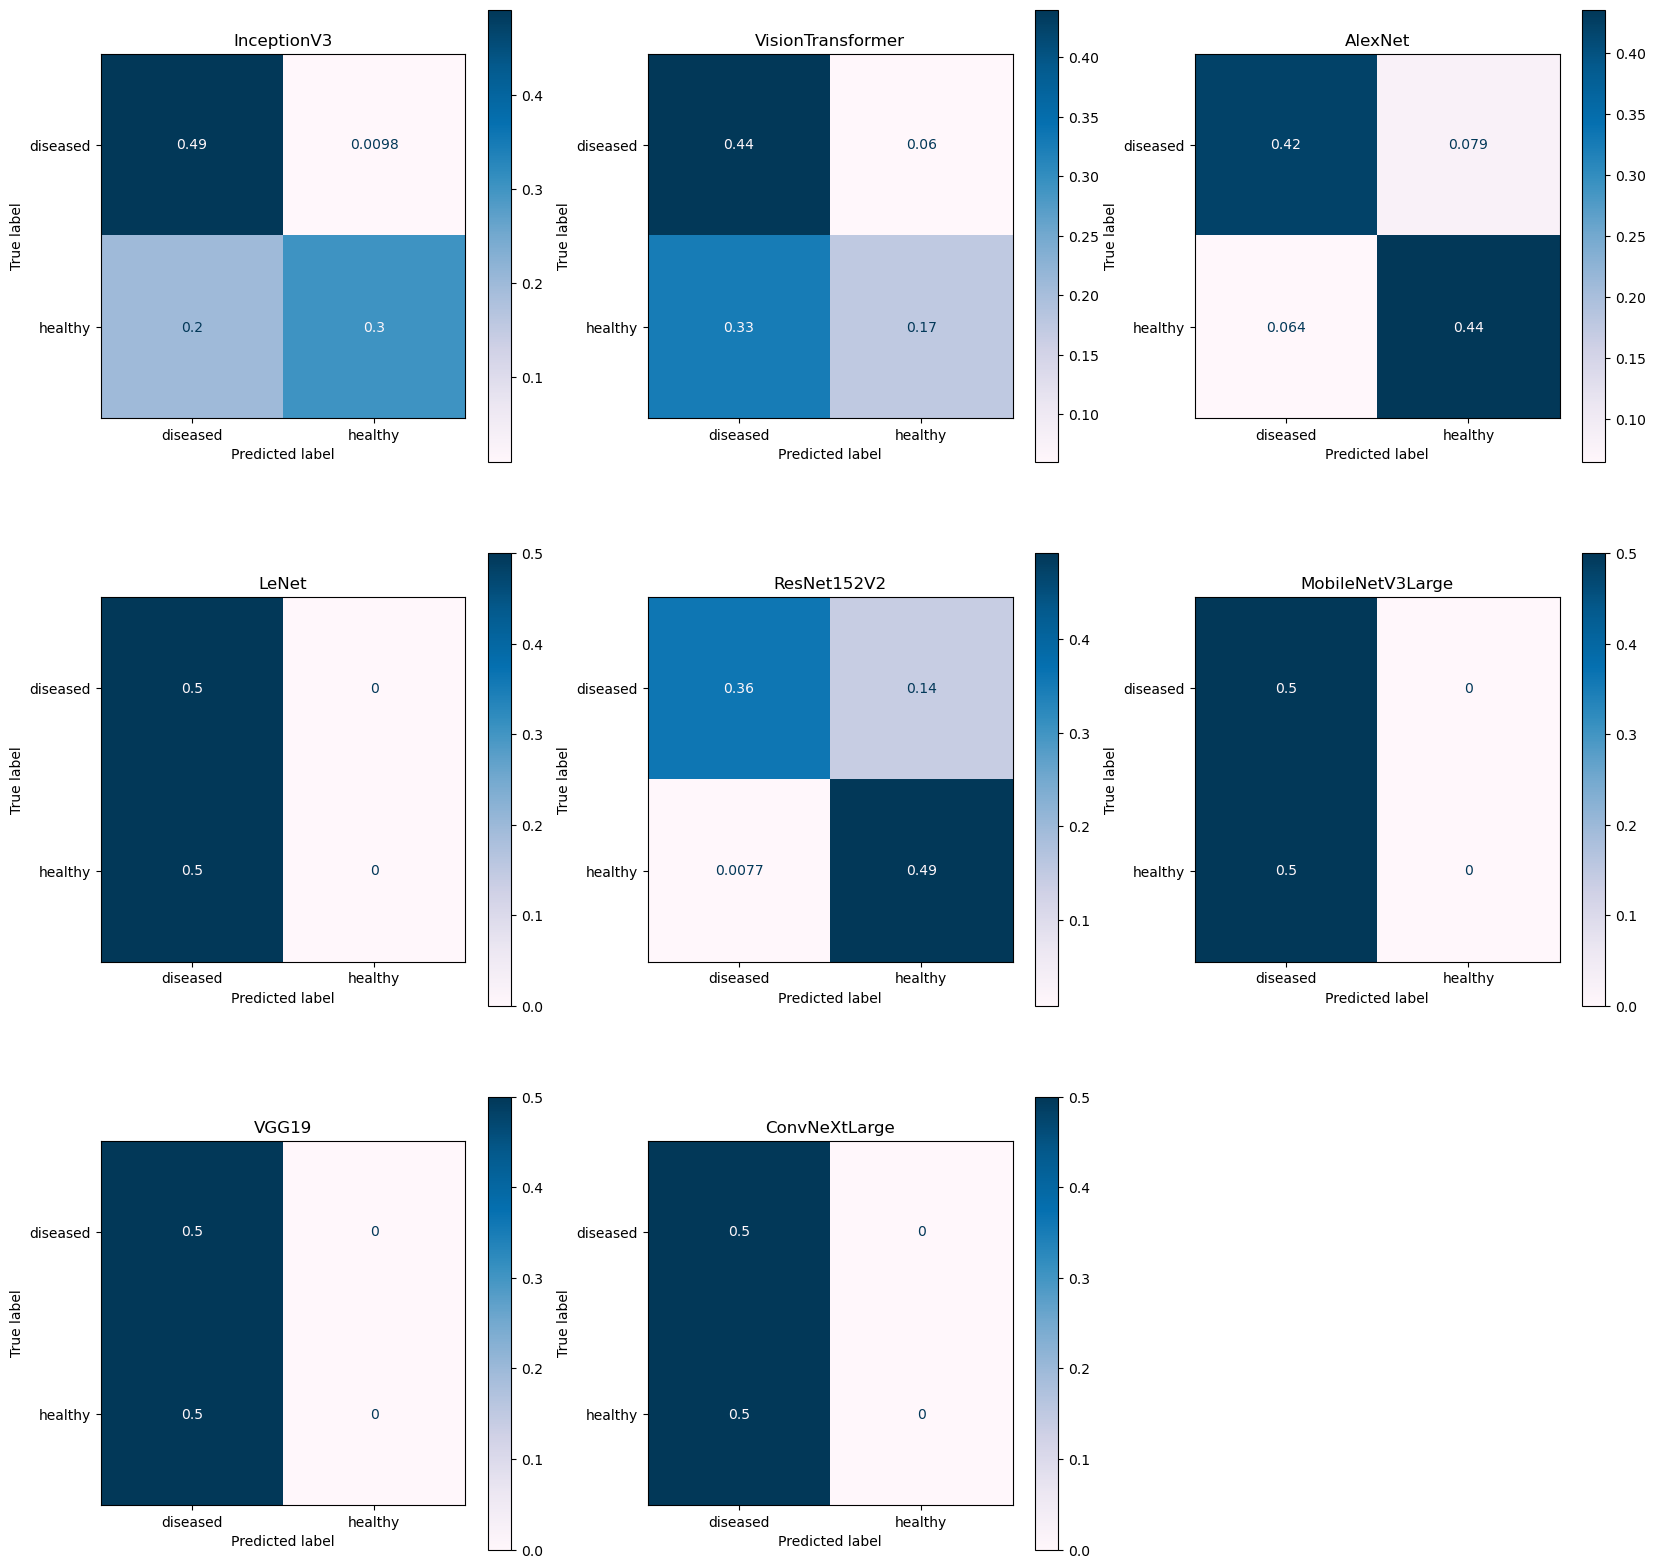

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.flatten()
axes[-1].axis('off')

for ax, (name, data) in zip(axes, preds.items()):
    y_true = np.argmax(data['y_true'], axis=1)
    
    y_pred = np.argmax(data['y_pred'], axis=1)
    total = len(y_true)
    unique, counts = np.unique(y_true, return_counts=True)
    label_weights = 1 - (counts / total)
    
    sample_weight = np.array([label_weights[label] for label in y_true])
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                                   cmap="PuBu", 
                                                   ax=ax, 
                                                   normalize='all', 
                                                   display_labels=["diseased", 'healthy'],
                                                   sample_weight=sample_weight)
    disp.ax_.set_title(name)
plt.show()

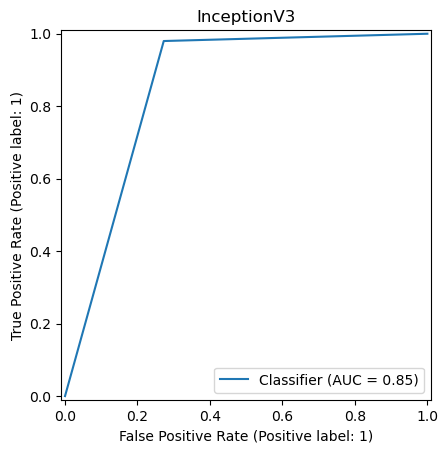

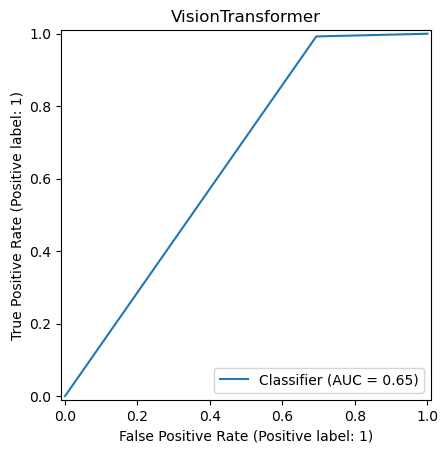

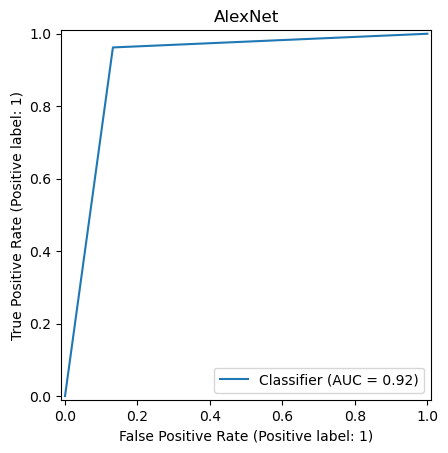

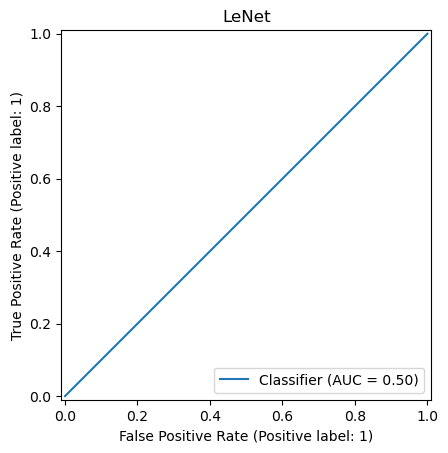

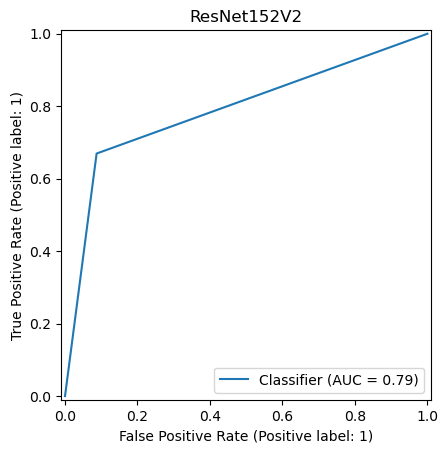

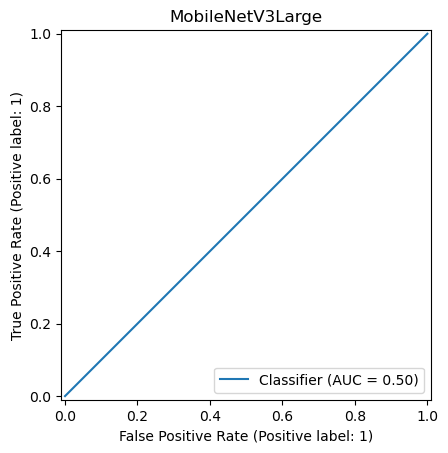

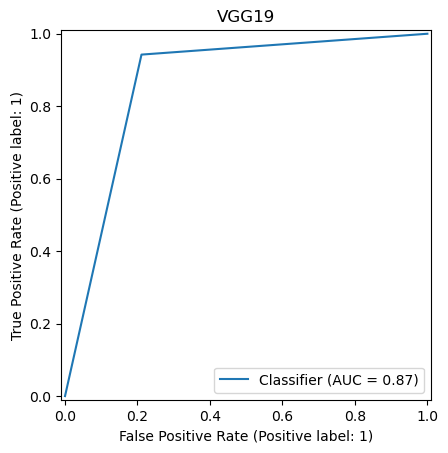

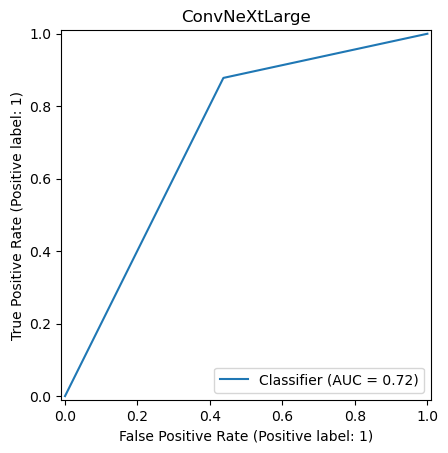

In [65]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
for name, data in preds.items():
    disp = RocCurveDisplay.from_predictions(reduce_y(data['y_true']), reduce_y(data['y_pred']))
    disp.ax_.set_title(name)
plt.show()

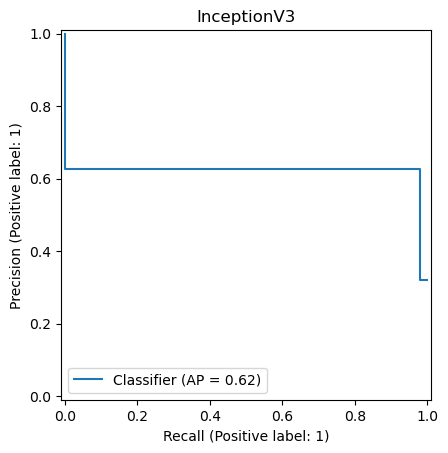

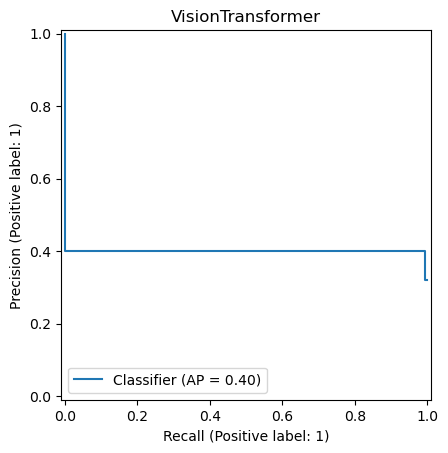

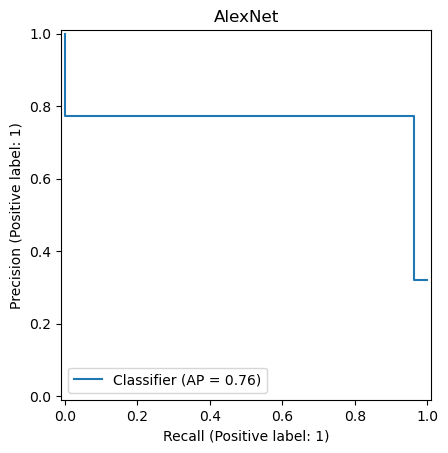

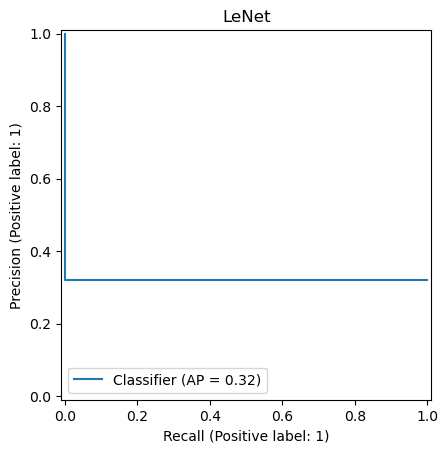

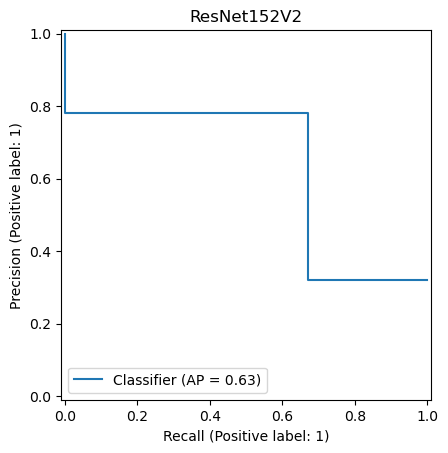

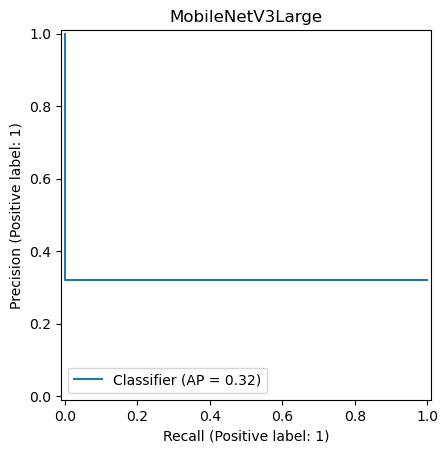

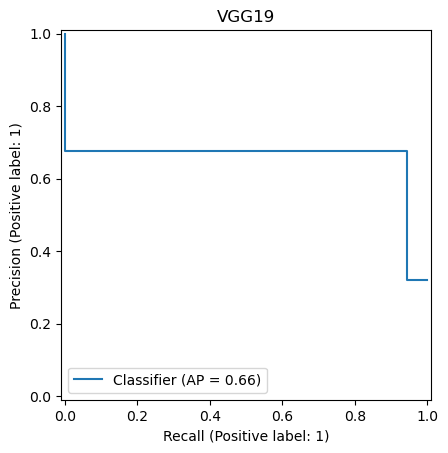

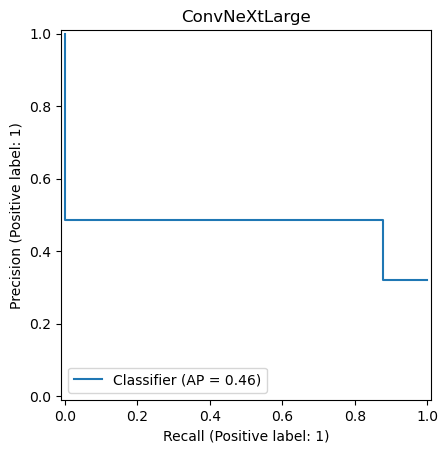

In [67]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt
for name, data in preds.items():
    disp = PrecisionRecallDisplay.from_predictions(reduce_y(data['y_true']), reduce_y(data['y_pred']))
    disp.ax_.set_title(name)
plt.show()